In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 年份
years = [2011, 2012, 2013, 2014, 2015, 
         2016, 2017, 2018, 2019, 2020]

no_edges =    [30028109, 29703867, 29296648, 28075557, 26794325,
               25507160, 24818510, 25292952, 23404572, 24190386]
one_edge =    [8383351,  8888316,  9544155,  10453935, 11184632,
               11611797, 11939939, 12266833, 12566114, 12733464]
two_edges =   [1280691,  1447995,  1712371,  2105519,  2520303,
               2858622,  3108896,  3230953,  3656024,  3673730]
three_edges = [221589,   260446,   332451,   446865,   582616,
               712421,   822655,   883657,   1063290,  1076815]

# 构造 DataFrame
df = pd.DataFrame({
    'year': years,
    'no_edges': no_edges,
    'one_edge': one_edge,
    'two_edges': two_edges,
    'three_edges': three_edges
})

# 如果后续把年份作为 index，会更方便做时间序列相关操作
df.set_index('year', inplace=True)
print(df)

      no_edges  one_edge  two_edges  three_edges
year                                            
2011  30028109   8383351    1280691       221589
2012  29703867   8888316    1447995       260446
2013  29296648   9544155    1712371       332451
2014  28075557  10453935    2105519       446865
2015  26794325  11184632    2520303       582616
2016  25507160  11611797    2858622       712421
2017  24818510  11939939    3108896       822655
2018  25292952  12266833    3230953       883657
2019  23404572  12566114    3656024      1063290
2020  24190386  12733464    3673730      1076815


In [2]:
corr_matrix = df.corr(method='pearson')
print("相关性矩阵：")
print(corr_matrix)

相关性矩阵：
             no_edges  one_edge  two_edges  three_edges
no_edges     1.000000 -0.976884  -0.990829    -0.983578
one_edge    -0.976884  1.000000   0.989351     0.971912
two_edges   -0.990829  0.989351   1.000000     0.995378
three_edges -0.983578  0.971912   0.995378     1.000000


In [8]:
# AR(1)（自回归）
# 如果估计出来的 𝛽 显著不为 0（且往往会 > 0），就可认为该三元组数量确实和上一期存在依赖关系。
# 在 Python 里可以用 statsmodels 来做一个最简单的回归（OLS）：
import statsmodels.api as sm
import numpy as np

y = df['no_edges'].iloc[1:]           # t=2012-2020
X = df['no_edges'].shift(1).iloc[1:]  # t-1=2011-2019
X = sm.add_constant(X)                # 加截距项

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               no_edges   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     45.10
Date:                Sun, 09 Feb 2025   Prob (F-statistic):           0.000273
Time:                        13:46:48   Log-Likelihood:                -134.86
No. Observations:                   9   AIC:                             273.7
Df Residuals:                       7   BIC:                             274.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.688e+06   3.53e+06      0.761      0.4

c:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


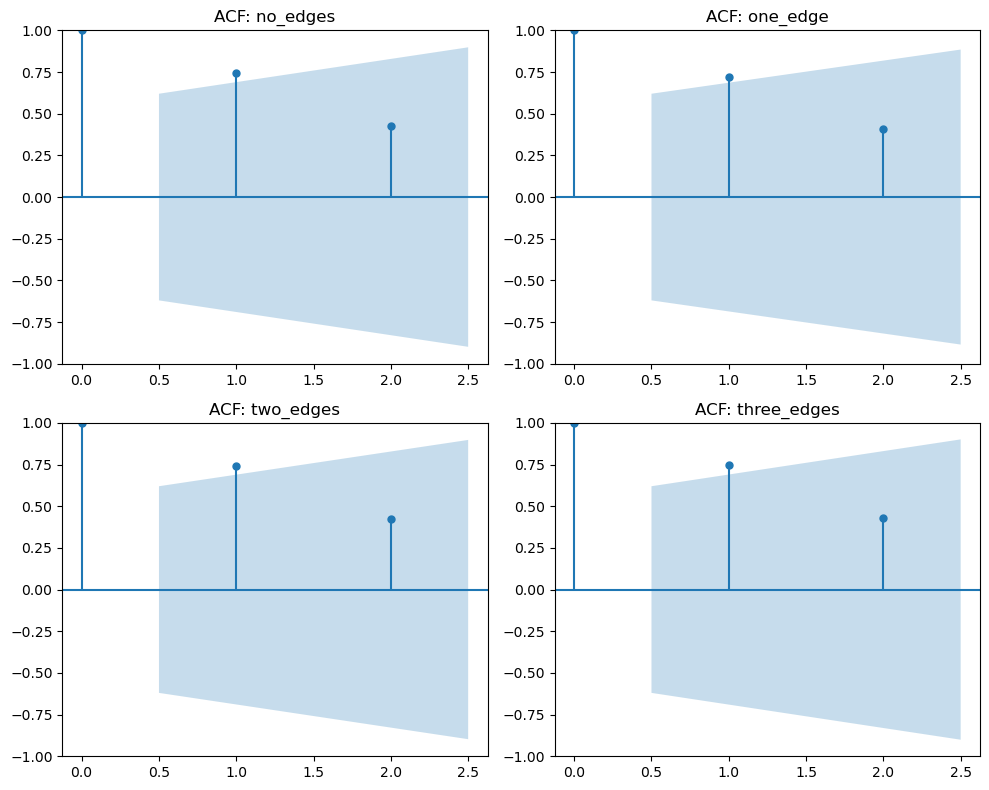

In [28]:
# 绘制 ACF（自相关）图
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# ACF: no_edges
plot_acf(df['no_edges'], ax=axs[0, 0], lags=2, title='ACF: no_edges')
# ACF: one_edge
plot_acf(df['one_edge'], ax=axs[0, 1], lags=2, title='ACF: one_edge')
# ACF: two_edges
plot_acf(df['two_edges'], ax=axs[1, 0], lags=2, title='ACF: two_edges')
# ACF: three_edges
plot_acf(df['three_edges'], ax=axs[1, 1], lags=2, title='ACF: three_edges')

plt.tight_layout()
plt.show()

In [18]:
triads = ['no_edges', 'one_edge', 'two_edges', 'three_edges']
lag1_corrs = []
lag2_corrs = []
lag3_corrs = []

for triad in triads:
    s = df[triad]
    # lag=1
    c1, p1 = stats.pearsonr(s[1:], s.shift(1)[1:])
    # lag=2
    c2, p2 = stats.pearsonr(s[2:], s.shift(2)[2:])
    # lag=3
    c3, p3 = stats.pearsonr(s[3:], s.shift(3)[3:])
    lag1_corrs.append(c1)
    lag2_corrs.append(c2)
    lag3_corrs.append(c3)

acf_df = pd.DataFrame({
    'triad': triads,
    'lag1': lag1_corrs,
    'lag2': lag2_corrs,
    'lag3': lag3_corrs
}).set_index('triad')

print(acf_df)

                 lag1      lag2      lag3
triad                                    
no_edges     0.930406  0.920531  0.859059
one_edge     0.992902  0.978499  0.979755
two_edges    0.986088  0.979464  0.967570
three_edges  0.984687  0.983026  0.967729


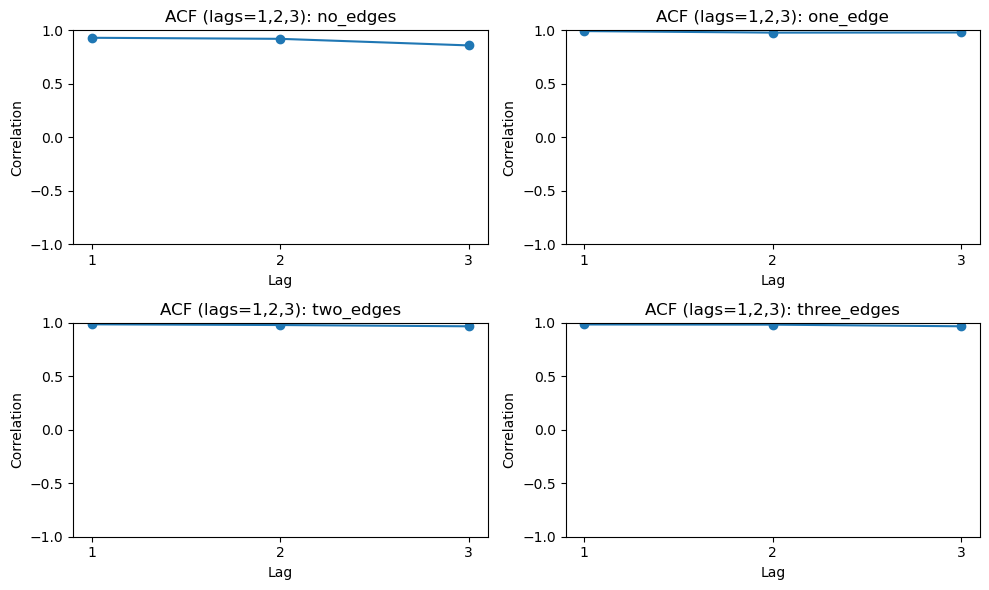

In [19]:
import matplotlib.pyplot as plt
import scipy.stats as stats

triads = ['no_edges', 'one_edge', 'two_edges', 'three_edges']

fig, axes = plt.subplots(2, 2, figsize=(10, 6))  # 2行×2列布局
axes = axes.flatten()  # 让axes是一个一维数组，方便循环

for i, triad in enumerate(triads):
    ax = axes[i]
    
    # 当前序列
    series = df[triad]
    
    # 计算 lag=1, lag=2, lag=3 的相关系数
    corr_values = []
    for lag in [1, 2, 3]:
        # 与前 lag 期对齐
        shifted = series.shift(lag)
        # 注意要去掉开头 NaN
        valid_idx = ~shifted.isna()
        
        # pearsonr 返回 (corr, p-value)
        corr, pval = stats.pearsonr(series[valid_idx], shifted[valid_idx])
        corr_values.append(corr)
    
    # 绘制折线图
    lags = [1, 2, 3]
    ax.plot(lags, corr_values, marker='o', linestyle='-')
    ax.set_xticks(lags)
    ax.set_ylim(-1, 1)
    ax.set_title(f'ACF (lags=1,2,3): {triad}')
    ax.set_xlabel('Lag')
    ax.set_ylabel('Correlation')

plt.tight_layout()
plt.show()

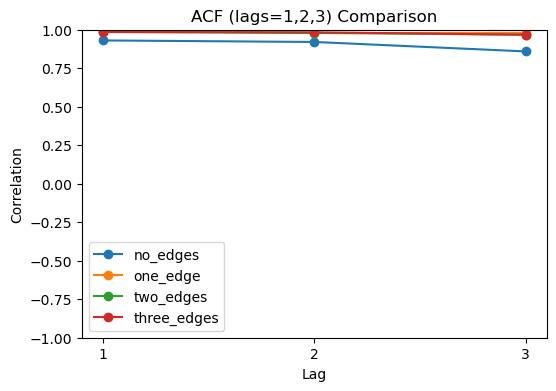

In [20]:
fig, ax = plt.subplots(figsize=(6,4))
lags = [1, 2, 3]

for triad in triads:
    series = df[triad]
    corr_values = []
    for lag in lags:
        shifted = series.shift(lag)
        valid_idx = ~shifted.isna()
        corr, _ = stats.pearsonr(series[valid_idx], shifted[valid_idx])
        corr_values.append(corr)
    
    ax.plot(lags, corr_values, marker='o', label=triad)

ax.set_xticks(lags)
ax.set_ylim(-1, 1)
ax.set_title('ACF (lags=1,2,3) Comparison')
ax.set_xlabel('Lag')
ax.set_ylabel('Correlation')
ax.legend()
plt.show()

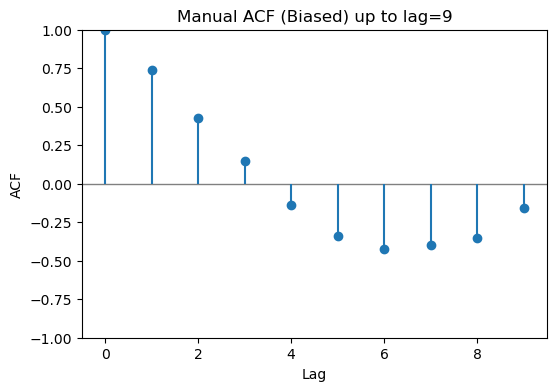

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.tsa.stattools import acf
from math import atanh, tanh, sqrt

def manual_acf(x, nlags=9, unbiased=False):
    """
    手动计算时间序列x的自相关函数(ACF),
    并返回 [acf(0), acf(1), ..., acf(nlags)].
    与statsmodels默认做法保持一致:
      - unbiased=False => "biased" 估计
      - 不做任何FFT
    """
    x = np.asarray(x)
    n = len(x)
    # 全局均值
    mean_x = x.mean()
    
    # 分母: (x_t - mean_x)^2 的总和
    c0 = np.sum((x - mean_x)**2)
    
    acf_values = []
    for k in range(nlags+1):
        # 分子：sum_{t=k}^{n-1} (x_t - mean_x)(x_{t-k} - mean_x)
        # 注意python索引: range(k, n) => t从k到n-1
        c_k = 0.0
        for t in range(k, n):
            c_k += (x[t] - mean_x) * (x[t - k] - mean_x)
        
        if unbiased:
            # 无偏估计: 乘上 n/(n-k)
            # statsmodels若unbiased=True，就会多乘此因子
            acf_k = (c_k / c0) * (n / (n - k))
        else:
            # biased估计 (默认)
            acf_k = c_k / c0
        
        acf_values.append(acf_k)
    
    return np.array(acf_values)


x = df['no_edges'].values
# 1) 用 manual_acf
my_acf = manual_acf(x, nlags=9, unbiased=False)  # array of length 10 (0~9)
lags = range(len(my_acf))  # 0..9

plt.figure(figsize=(6,4))

# 先画水平线 y=0 作为参考
plt.axhline(y=0, color='gray', linewidth=1)

# 画棍棒图
for i in lags:
    plt.vlines(x=i, ymin=0, ymax=my_acf[i], color='C0')
# 在顶端加一个圆点
plt.plot(lags, my_acf, 'o', color='C0')

plt.title('Manual ACF (Biased) up to lag=9')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.ylim(-1, 1)
plt.xlim(-0.5, 9.5)
plt.show()

